## 1. Load libraries

In [40]:
# Import pandas as pd  

import pandas as pd

# Ignore the warnings

import warnings
warnings.filterwarnings('ignore')

# Import pipelines and encoders libraries.

from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, fbeta_score
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt
from sklearn.metrics import precision_recall_curve

# Import sklearn models and pipeline.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Import lineal regression model.

from sklearn.linear_model import LinearRegression

# Import mean absolute error

from sklearn.metrics import mean_absolute_error

# Import pickle

import pickle

## 2. Import of data

In [2]:
# Load the csv file

df = pd.read_csv('data/processed/final_df_EDA.csv')

# Head of the data

df.head()

,ID,ADDRESS,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DAYS_BIRTH_CLEAN,Letter,STATUS
0,5008804,"06042, CT, 31 Mitchell Road",Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-4542.0,1.0,1.0,0.0,0.0,Other,2.0,09/04/1990,L,1
1,5008804,"06042, CT, 31 Mitchell Road",N,Y,1.0,90000.0,State servant,Secondary / secondary special,Married,House / apartment,-3659.0,1.0,0.0,0.0,0.0,Medicine staff,3.0,07/06/1984,L,1
2,5008805,"72703, AR, 1189 Northwest End Avenue",Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-4542.0,1.0,1.0,0.0,0.0,Other,2.0,09/04/1990,G,1
3,5008805,"72703, AR, 1189 Northwest End Avenue",N,Y,0.0,180000.0,Working,Higher education,Civil marriage,With parents,-390.0,1.0,0.0,0.0,0.0,Sales staff,2.0,21/02/1995,G,1
4,5008806,"72701, AR, 218 Shipley Alley",Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,06/05/1964,D,0


## 3. Selection of variables

We proceed to quickly convert the format to date and keep only the year.

In [3]:
# Convert DAYS_BIRTH_CLEAN to datetime

df['DAYS_BIRTH_CLEAN'] = pd.to_datetime(df['DAYS_BIRTH_CLEAN'])

# For DAYS_BIRTH_CLEAN just select the year.

df['DAYS_BIRTH_CLEAN'] = df['DAYS_BIRTH_CLEAN'].apply(lambda x: x.year)


For the creation of the model we will remove `ID`, `Letter` and `Address`, as they are not relevant for our model.

In [4]:
# Drop the ID column, Address, Letter column.

df.drop(['ID', 'ADDRESS', 'Letter'], axis=1, inplace=True)

We separate between categorical and numerical variables:

In [5]:
# Create a dataframe with all the categorical variables: FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE, OCCUPATION_TYPE, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL

cat_var_df = df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','DAYS_BIRTH_CLEAN']]

# Create a dataframe with all the numerical variables, taht are the rest.

num_var_df = df[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED','CNT_FAM_MEMBERS']]

## 4. Transformation of variables

We look at how many different data types there are for each variable to decide how to convert them.

In [6]:
# Show number of distinct values for each categorical variable

cat_var_df.nunique()

FLAG_OWN_CAR            3
FLAG_OWN_REALTY         3
NAME_INCOME_TYPE        5
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        19
FLAG_MOBIL              2
FLAG_WORK_PHONE         2
FLAG_PHONE              2
FLAG_EMAIL              2
DAYS_BIRTH_CLEAN       49
dtype: int64

### 4.1 Categorical variables

In [12]:
# Convert the categorical variables to string

cat_var_df = cat_var_df.astype(str)

# Separate cat_var_df in two lists, depending if the variables have more or less than 5 different values.

cat_var_df_short = cat_var_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']]
cat_var_df_long = cat_var_df[['OCCUPATION_TYPE','DAYS_BIRTH_CLEAN']]


In [14]:
# Create a one hot encoder of car_var_df

ohe = OneHotEncoder(handle_unknown='ignore')

# Fit the one hot encoder

ohe.fit(cat_var_df_short)

# Transform the categorical variables

cat_var_df_onehot = ohe.transform(cat_var_df_short)

# Create a dataframe with the one hot encoded variables

cat_var_df_onehot = pd.DataFrame(cat_var_df_onehot.toarray(), columns=ohe.get_feature_names())




In [18]:
# Use target encoder for the long categorical variables

te = TargetEncoder()

# Fit the target encoder between 0 and 1 without the target variable

te.fit(cat_var_df_long, df['STATUS'])

# Transform the categorical variables

cat_var_df_target = te.transform(cat_var_df_long)

# Create a dataframe with the target encoded variables

cat_var_df_target = pd.DataFrame(cat_var_df_target, columns=cat_var_df_long.columns)

# Concatenate the one hot encoded and target encoded variables

cat_var_df = pd.concat([cat_var_df_onehot, cat_var_df_target], axis=1)

In [174]:
# Create a one hot encoder of car_var_df

ohe = OneHotEncoder(handle_unknown='ignore')

# Fit the one hot encoder

ohe.fit(cat_var_df)

# Transform the categorical variables

cat_var_df_onehot = ohe.transform(cat_var_df)

# Create a dataframe with the one hot encoded variables

cat_var_df_onehot = pd.DataFrame(cat_var_df_onehot.toarray(), columns=ohe.get_feature_names())




In [177]:
# Convert to string cat_var_df

cat_var_df.FLAG_OWN_CAR = cat_var_df.FLAG_OWN_CAR.astype(str)

In [178]:
# Check the type of cat_var_df

cat_var_df.dtypes

FLAG_OWN_CAR           object
FLAG_OWN_REALTY        object
NAME_INCOME_TYPE       object
NAME_EDUCATION_TYPE    object
NAME_FAMILY_STATUS     object
NAME_HOUSING_TYPE      object
OCCUPATION_TYPE        object
FLAG_MOBIL             object
FLAG_WORK_PHONE        object
FLAG_PHONE             object
FLAG_EMAIL             object
DAYS_BIRTH_CLEAN       object
dtype: object

In [179]:
cat_var_df

,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,DAYS_BIRTH_CLEAN
0,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Other,1.0,1.0,0.0,0.0,1990
1,N,Y,State servant,Secondary / secondary special,Married,House / apartment,Medicine staff,1.0,0.0,0.0,0.0,1984
2,Y,Y,Working,Higher education,Civil marriage,Rented apartment,Other,1.0,1.0,0.0,0.0,1990
3,N,Y,Working,Higher education,Civil marriage,With parents,Sales staff,1.0,0.0,0.0,0.0,1995
4,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Security staff,1.0,0.0,0.0,0.0,1964
...,...,...,...,...,...,...,...,...,...,...,...,...
31503,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Other,1.0,0.0,0.0,0.0,1970
31504,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers,1.0,0.0,1.0,0.0,1978
31505,N,Y,Commercial associate,Higher education,Married,House / apartment,Medicine staff,0.0,0.0,1.0,1.0,1989
31506,N,Y,Working,Secondary / secondary special,Married,House / apartment,Sales staff,1.0,0.0,0.0,0.0,1973


In [180]:
# Separate cat_var_df in two lists, depending if the variables have more or less than 5 different values.

cat_var_df_long = cat_var_df[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']]
cat_var_df_short = cat_var_df[['OCCUPATION_TYPE','DAYS_BIRTH_CLEAN']]


In [181]:
cat_var_df_short

,OCCUPATION_TYPE,DAYS_BIRTH_CLEAN
0,Other,1990
1,Medicine staff,1984
2,Other,1990
3,Sales staff,1995
4,Security staff,1964
...,...,...
31503,Other,1970
31504,Laborers,1978
31505,Medicine staff,1989
31506,Sales staff,1973


In [182]:
#short_cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])



In [183]:
#long_cat_transformer = Pipeline(steps=[
    #('target', TargetEncoder(handle_unknown='ignore'))])


In [21]:
# Creation of a pipeline for numerical variables that standardize each variable

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

In [22]:
# Make scalar transformation for numerical variables

num_transformer.fit(num_var_df)

# Transform the numerical variables

num_var_df_scaled = num_transformer.transform(num_var_df)

# Create a dataframe with the scaled numerical variables

num_var_df_scaled = pd.DataFrame(num_var_df_scaled, columns=num_var_df.columns)

num_var_df_scaled

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,-0.568863,2.403077,-0.462364,-0.154169
1,0.787762,-0.946653,-0.455938,0.887777
2,-0.568863,2.403077,-0.462364,-0.154169
3,-0.568863,-0.053392,-0.432145,-0.154169
4,-0.568863,-0.723338,-0.437560,-0.154169
...,...,...,...,...
31503,-0.568863,-0.946653,-0.441833,-0.154169
31504,-0.568863,-0.544685,-0.497657,-0.154169
31505,-0.568863,-0.276707,-0.438951,-0.154169
31506,-0.568863,0.973859,-0.434074,-0.154169


In [23]:
# Join the cat_var_df_onehot and num_var_df_scaled dataframes

df_modelo = pd.concat([cat_var_df, num_var_df_scaled], axis=1)

In [24]:
df_modelo

,x0_0,x0_N,x0_Y,x1_0,x1_N,x1_Y,x2_Commercial associate,x2_Pensioner,x2_State servant,x2_Student,...,x8_0.0,x8_1.0,x9_0.0,x9_1.0,OCCUPATION_TYPE,DAYS_BIRTH_CLEAN,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.105518,0.139976,-0.568863,2.403077,-0.462364,-0.154169
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.138643,0.112676,0.787762,-0.946653,-0.455938,0.887777
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.105518,0.139976,-0.568863,2.403077,-0.462364,-0.154169
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.111992,0.137446,-0.568863,-0.053392,-0.432145,-0.154169
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.154455,0.124172,-0.568863,-0.723338,-0.437560,-0.154169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31503,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.105518,0.149206,-0.568863,-0.946653,-0.441833,-0.154169
31504,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.117356,0.119231,-0.568863,-0.544685,-0.497657,-0.154169
31505,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.138643,0.127778,-0.568863,-0.276707,-0.438951,-0.154169
31506,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.111992,0.104294,-0.568863,0.973859,-0.434074,-0.154169


In [188]:
# Creation of a preprocessor for the categorical and numerical variables.

#preprocessor = ColumnTransformer(
    #transformers=[
        #('short_cat', short_cat_transformer, cat_var_df_long),
        #('long_cat', long_cat_transformer, cat_var_df_short),
        #('num', num_transformer, num_var_df)
    ]
)

# Save the preprocessor as .pickle.

#with open('preprocessor.pickle', 'wb') as f:
    #pickle.dump(preprocessor, f)

In [25]:
X = df_modelo
Y = df['STATUS'].reset_index(drop=True)

### 4.2. Division train y test

In [26]:
# Divide the dataset into train and test with stratification

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=12345,stratify=Y)

## 5. XGBOOST

In [29]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model = Pipeline([
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])

In [30]:
# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model.fit(x_train, y_train)

Pipeline(steps=[('clasificador',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
          

In [31]:
# Predict the target value of the validation set.

predictions = xgb_model.predict(x_train)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = xgb_model.predict_proba(x_train)

In [32]:
# Print the general metrics.

print(classification_report(y_train, predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     20854
           1       0.86      0.18      0.29      2777

    accuracy                           0.90     23631
   macro avg       0.88      0.59      0.62     23631
weighted avg       0.90      0.90      0.87     23631



In [33]:

# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_train, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_train, predictions))

F2 score is 0.21100838897449065
Accuracy: 0.8999195971393509


In [34]:
# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model.fit(x_test, y_test)

Pipeline(steps=[('clasificador',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
          

In [35]:
# Predict the target value of the validation set.

predictions = xgb_model.predict(x_test)


In [36]:

# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_test, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_test, predictions))

F2 score is 0.4279058361942129
Accuracy: 0.9235749650882316


In [37]:
# Import matplotlib and seaborn.

import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Import sklearn metrics
from sklearn.metrics import roc_auc_score

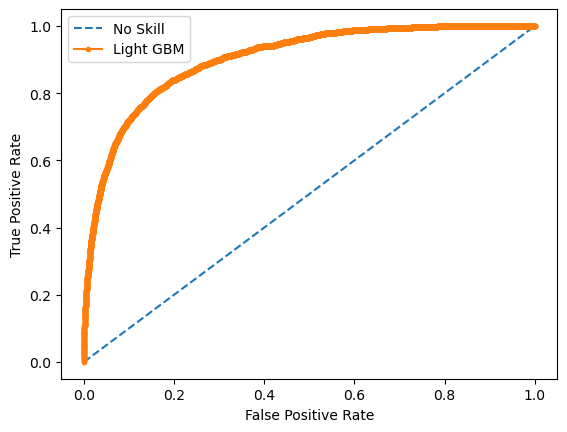

The Compute Area Under the Receiver Operating Characteristic is 0.9026751102085702


In [39]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Light GBM')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(roc_auc_score(y_train,yhat)))

Probamos con una regresión lineal:

In [108]:
lr = LinearRegression().fit(x_train, y_train)
lr_predictions = lr.predict(x_train)
lr_mae = mean_absolute_error(y_train, lr_predictions)
lr_predictions_Train = lr.predict(x_train)
lr_mae_Train = mean_absolute_error(y_train, lr_predictions_Train)

## 6. Multi-Class Model (Under development)

In [118]:
# Load the final_df_multilabel dataset.

df2 = pd.read_csv('data/processed/final_df_multilabel.csv')

# Distinct status of df2.

df2.STATUS.unique()


array([1, 0, 2, 3, 4], dtype=int64)

In [122]:
# Load the csv file

df2 = pd.read_csv('data/processed/final_df_EDA.csv')

# Convert DAYS_BIRTH_CLEAN to datetime

df2['DAYS_BIRTH_CLEAN'] = pd.to_datetime(df2['DAYS_BIRTH_CLEAN'])


# For DAYS_BIRTH_CLEAN just select the year.

df2['DAYS_BIRTH_CLEAN'] = df2['DAYS_BIRTH_CLEAN'].apply(lambda x: x.year)


# Drop the ID column, Address, Letter column.

df2.drop(['ID', 'Address', 'Letter'], axis=1, inplace=True)

In [129]:
# Create a dataframe with all the categorical variables: FLAG_OWN_CAR, FLAG_OWN_REALTY, NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE, OCCUPATION_TYPE, FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL

cat_var_df_2 = df2[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL','DAYS_BIRTH_CLEAN']]

In [130]:
# Create a dataframe with all the numerical variables, taht are the rest.

num_var_df_2= df2[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED','CNT_FAM_MEMBERS']]

In [133]:
# Convert the categorical variables to string

cat_var_df_2 = cat_var_df_2.astype(str)

# Create a one hot encoder of car_var_df

ohe2 = OneHotEncoder(handle_unknown='ignore')

# Fit the one hot encoder

ohe2.fit(cat_var_df_2)

# Transform the categorical variables

cat_var_df_onehot_2 = ohe2.transform(cat_var_df_2)

# Create a dataframe with the one hot encoded variables

cat_var_df_onehot_2 = pd.DataFrame(cat_var_df_onehot_2.toarray(), columns=ohe.get_feature_names())


In [134]:
# Convert to string cat_var_df

cat_var_df_2.FLAG_OWN_CAR = cat_var_df_2.FLAG_OWN_CAR.astype(str)

In [135]:
# Make scalar transformation for numerical variables

num_transformer.fit(num_var_df_2)

# Transform the numerical variables

num_var_df_scaled_2 = num_transformer.transform(num_var_df_2)

# Create a dataframe with the scaled numerical variables

num_var_df_scaled_2 = pd.DataFrame(num_var_df_scaled_2, columns=num_var_df_2.columns)

num_var_df_scaled_2


,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,-0.568863,2.403077,-0.462364,-0.154169
1,0.787762,-0.946653,-0.455938,0.887777
2,-0.568863,2.403077,-0.462364,-0.154169
3,-0.568863,-0.053392,-0.432145,-0.154169
4,-0.568863,-0.723338,-0.437560,-0.154169
...,...,...,...,...
31503,-0.568863,-0.946653,-0.441833,-0.154169
31504,-0.568863,-0.544685,-0.497657,-0.154169
31505,-0.568863,-0.276707,-0.438951,-0.154169
31506,-0.568863,0.973859,-0.434074,-0.154169


In [136]:
# Join the cat_var_df_onehot and num_var_df_scaled dataframes

df_modelo_2 = pd.concat([cat_var_df_onehot_2, num_var_df_scaled_2], axis=1)

In [143]:
X_2 = df_modelo_2
Y_2 = df['STATUS'].reset_index(drop=True)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X_2, Y_2, test_size=0.25, random_state=12345)

In [144]:

# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model = Pipeline([
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])

# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model.fit(x_train2, y_train2)

# Predict the target value of the validation set.

predictions = xgb_model.predict(x_train2)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = xgb_model.predict_proba(x_train)


In [146]:
# Print the F2 score.

print('F2 score is ' + str(fbeta_score(y_train2, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_train2, predictions))

F2 score is 0.1745962461807071
Accuracy: 0.8983538572214465


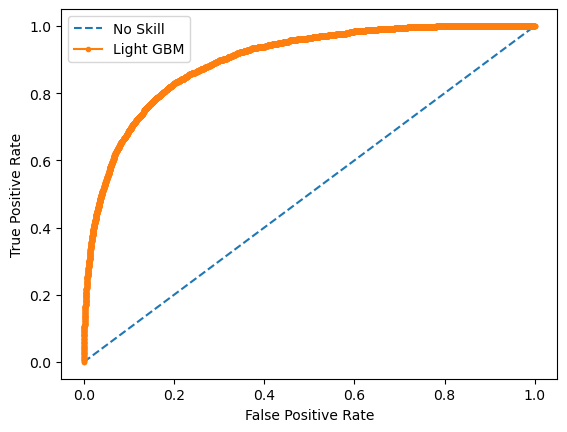

In [141]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_train, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Light GBM')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

In [117]:
X

,x0_0,x0_N,x0_Y,x1_0,x1_N,x1_Y,x2_Commercial associate,x2_Pensioner,x2_State servant,x2_Student,...,x11_1997,x11_1998,x11_1999,x11_2000,x11_2001,x11_2002,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_FAM_MEMBERS
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,2.403077,-0.462364,-0.154169
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.787762,-0.946653,-0.455938,0.887777
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,2.403077,-0.462364,-0.154169
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,-0.053392,-0.432145,-0.154169
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,-0.723338,-0.437560,-0.154169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31503,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,-0.946653,-0.441833,-0.154169
31504,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,-0.544685,-0.497657,-0.154169
31505,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,-0.276707,-0.438951,-0.154169
31506,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.568863,0.973859,-0.434074,-0.154169
